In [9]:
import sys
sys.path.append("..")

In [10]:
import matplotlib.pylab as plt
import numpy as np
from squlearn.encoding_circuit import ChebyshevPQC, ChebyshevTower
from squlearn.kernel import ProjectedQuantumKernel
from squlearn.kernel.ml import QKODE

from squlearn.kernel.optimization import KernelOptimizer, ODE_loss
from squlearn.optimizers import Adam, LBFGSB
from squlearn.util import Executor

In [11]:
x_train = np.linspace(0.001, 0.9, 40)
y_train = [np.log(0.001)] #y_initial
feature_map = ChebyshevPQC(num_qubits=4, num_features=1, num_layers=1)
feature_map = ChebyshevTower(num_qubits=6, num_features=1, num_layers=1, num_chebyshev=4)
q_kernel = ProjectedQuantumKernel(feature_map, Executor())

In [15]:
#from DE_Library.diferential_equation_functionals import loss_log_ode
def loss_log_ode(f_alpha_tensor):
    """
    0 = -lamb * np.exp(f * k) + df/dx
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor 

    lamb = 1
    k = 1
    return dfdx - np.exp(-f*k)*lamb 

q_kode = QKODE(quantum_kernel=q_kernel, L_functional=loss_log_ode, optimizer=LBFGSB())

In [13]:
q_kode.fit(x_train, y_train, regularization_parameter = 0.005, initial_parameters_classical=np.random.rand(41))
prediction = q_kode.predict()

Calculating f
Calculating dfdx
Calculating f
Calculating f


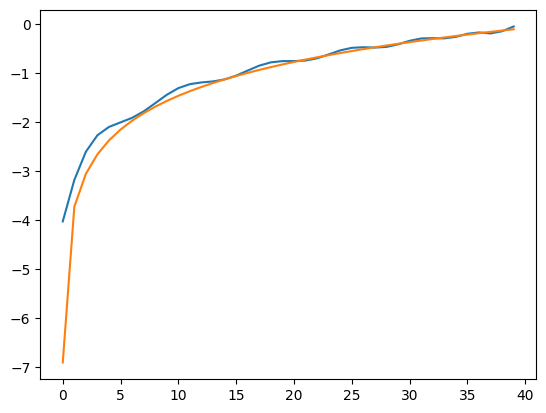

In [14]:
plt.plot(prediction)
plt.plot(np.log(x_train))